In [281]:
import pandas as pd
import numpy as np
from collections import defaultdict

In [80]:
format = pd.read_csv('pokemon_format.csv')
tipo = pd.read_csv('pokemon_type.csv')
stats = pd.read_csv('pokemon.csv')

In [81]:
stats.rename(columns={'id':'pokemon_id'}, inplace=True)
# stats.dropna(inplace=True)
# stats.drop(columns=['weight', 'height'], inplace=True)

In [82]:
# change tipo so that each line represents one pokemon_id, and each column represents a type
tipo_dict = defaultdict()
for i in range(len(tipo)):
    id = tipo.iloc[i]['pokemon_id']
    if id not in tipo_dict.keys():
        tipo_dict[id] = {"Type 1": tipo.iloc[i]['types'], "Type 2": 'None'}
    else:
        tipo_dict[id]["Type 2"] = tipo.iloc[i]['types']

In [83]:
tipo = pd.DataFrame(tipo_dict).T
# convert id to column
tipo.reset_index(inplace=True)
tipo.rename(columns={'index':'pokemon_id'}, inplace=True)
tipo

,pokemon_id,Type 1,Type 2
0,0,Grass,Poison
1,1,Bug,None
2,2,Electric,None
3,3,Electric,None
4,4,Grass,Psychic
...,...,...,...
6618,6618,Normal,Fighting
6619,6619,Water,None
6620,6620,Water,None
6621,6621,Flying,Water


In [84]:
# join format and stats on pokemon_id
format_stats = pd.merge(format, stats, on='pokemon_id')
# join format_stats and tipo on pokemon_id
format_stats_tipo = pd.merge(format_stats, tipo, on='pokemon_id')

In [86]:
# filtering unwanted data
format_stats_tipo = format_stats_tipo[format_stats_tipo['formats'] != 'National Dex']
format_stats_tipo = format_stats_tipo[format_stats_tipo['formats'] != 'Untiered']
format_stats_tipo = format_stats_tipo[format_stats_tipo['formats'] != 'CAP']

# get only most recent data
format_stats_tipo.sort_values(by=['dex_number', 'pokemon_id'], inplace=True)
format_stats_tipo.drop_duplicates(subset=['dex_number'], keep='last', inplace=True)

# clean up
format_stats_tipo.drop(columns=['id', 'pokemon_id'], inplace=True)
format_stats_tipo.dropna(inplace=True)
format_stats_tipo.reset_index(inplace=True, drop=True)
format_stats_tipo

KeyError: 'pokemon_id'

In [87]:
# save data
format_stats_tipo.to_csv('pokemon_clean.csv', index=False)

In [120]:
dataf = pd.read_csv('pokemon_clean.csv')
dataf["is_Strong"] = dataf["formats"].apply(lambda x: 1 if x == "Uber" or x == "OU" or x == "UUBL" else 0)

In [121]:
dataf

,formats,gen,name,hp,atk,def,spa,spd,spe,weight,height,isNonstandard,dex_number,alias,Type 1,Type 2,is_Strong
0,LC,ss,Bulbasaur,45,49,49,65,65,45,6.9,0.7,Standard,1.0,bulbasaur,Grass,Poison,0
1,NFE,ss,Ivysaur,60,62,63,80,80,60,13.0,1.0,Standard,2.0,ivysaur,Grass,Poison,0
2,UU,ss,Venusaur,80,82,83,100,100,80,100.0,2.0,Standard,3.0,venusaur,Grass,Poison,0
3,LC,sv,Charmander,39,52,43,60,50,65,8.5,0.6,Standard,4.0,charmander,Fire,None,0
4,NFE,sv,Charmeleon,58,64,58,80,65,80,19.0,1.1,Standard,5.0,charmeleon,Fire,None,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
975,OU,sv,Iron Valiant,74,130,90,120,60,116,35.0,1.4,Standard,1006.0,iron-valiant,Fairy,Fighting,1
976,Uber,sv,Koraidon,100,135,115,85,100,135,303.0,2.5,Standard,1007.0,koraidon,Fighting,Dragon,1
977,Uber,sv,Miraidon,100,85,100,135,115,135,240.0,3.5,Standard,1008.0,miraidon,Electric,Dragon,1
978,OU,sv,Walking Wake,99,83,91,125,83,109,280.0,3.5,Standard,1009.0,walking-wake,Water,Dragon,1


In [310]:
# split into training and test data
from sklearn.model_selection import train_test_split

train, test = train_test_split(dataf, test_size=0.2, random_state=42)
test, val = train_test_split(test, test_size=0.5, random_state=31)
pd.DataFrame(train).to_csv('train.csv', index=False)
pd.DataFrame(test).to_csv('test.csv', index=False)
pd.DataFrame(val).to_csv('val.csv', index=False)

data = train

In [311]:
import plotly.express as px

# plot box plot for each of the six stats, colored by is_Strong
fig = px.box(data, x="is_Strong", y="hp", color="is_Strong", hover_data=data.columns)
fig.show()


In [312]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

vars = ['hp', 'atk', 'def', 'spa', 'spd', 'spe']
fig = make_subplots(rows=1, cols=len(vars))
for i, var in enumerate(vars):
    fig.add_trace(
        go.Box(y=data[var],
        name=var),
        row=1, col=i+1
    )

fig.update_traces(boxpoints='all', jitter=.3)

In [313]:
# make a change to the code above that makes it so each box plot has two columns, is_Strong

fig1 = make_subplots(rows=2, cols=int(len(vars)/2), subplot_titles=vars, vertical_spacing=0.1)
# make fig bigger
fig1.update_layout(height=800, width=1000)
for i, var in enumerate(vars):
    fig1.add_trace(
        go.Box(y=data[var], x=data['is_Strong'],
        name=var),
        row=1 if i < 3 else 2, 
        col=i+1 if i < 3 else i-2,
    )
# lower spacing between plots
fig1.update_layout(showlegend=False, margin=dict(l=10, r=10, t=30, b=10))
fig1.update_traces(boxpoints='all', jitter=.3)
fig1.update_xaxes(title_text='is Strong')

In [315]:
# get scatter matrix of 6 stats and weight and height, color being discrete
aux_data = data[['hp', 'atk', 'def', 'spa', 'spd', 'spe', 'weight', 'height', 'is_Strong']]
aux_data['is_Strong'] = aux_data['is_Strong'].astype(str)
fig3 = px.scatter_matrix(aux_data, dimensions=['hp', 'atk', 'def', 'spa', 'spd', 'spe', 'weight', 'height'], color='is_Strong', opacity=0.4, color_discrete_sequence=px.colors.qualitative.Set1)
fig3.update_layout(height=1000, width=1200)
fig3.update_layout(showlegend=True, margin=dict(l=10, r=10, t=30, b=10))
fig3.update_traces(diagonal_visible=False)

/tmp/ipykernel_801/1989053187.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [316]:
vars = ['height', 'weight']
fig5 = make_subplots(rows=1, cols=2, subplot_titles=vars, vertical_spacing=0.1)
# make fig bigger
colors = px.colors.qualitative.Set1
fig5.update_layout(height=500, width=800)
for i, var in enumerate(vars):
    for j, is_Strong in enumerate(data['is_Strong'].unique()):
        df_plot = data[data['is_Strong'] == is_Strong]
        fig5.add_trace(
            go.Box(y=df_plot[var], x=df_plot['is_Strong'],
            name=var, line=dict(color=colors[j])),
            row=1 if i < 3 else 2, 
            col=i+1 if i < 3 else i-2,
        )

# lower spacing between plots
fig5.update_layout(showlegend=False, margin=dict(l=10, r=10, t=30, b=10))
fig5.update_traces(boxpoints='all', jitter=.3)
fig5.update_xaxes(title_text='is Strong')

In [317]:
# get percentage of strong pokemon for each type
strong = data[data['is_Strong'] == 1]
strong = strong.groupby(['Type 1']).count()
types = data.groupby(['Type 1']).count() # total amount of each type

strong2 = data[data['is_Strong'] == 1]
strong2 = strong2.groupby(['Type 2']).count()
strong2 = strong2[strong2.index != "None"]
strong2.loc['Bug'] = 0  # add a line where index is Bug to strong2, because there are no pokemon with type 2 Bug
types2 = data.groupby(['Type 2']).count() #
types2 = types2[types2.index != "None"]

types += types2
strong += strong2

strong['strong_count'] = strong['is_Strong']
strong['total_count'] = types['is_Strong']
strong['strong_percentage'] = strong['strong_count'] / strong['total_count']
strong = strong[['strong_percentage']]

strong.sort_values(by=['strong_percentage'], inplace=True, ascending=False)

# rename id to Type
strong.reset_index(inplace=True)
strong.rename(columns={'Type 1':'Type'}, inplace=True)

# plot bar chart
fig2 = px.bar(strong, y='Type', x='strong_percentage')
fig2.update_layout(height=800, width=400)
# make space between bars smaller
fig2.update_layout(bargap=0.1, margin=dict(l=10, r=10, t=30, b=10))
fig2.update_xaxes(title_text='Percentage of Strong Pokémon')
fig2.show()

In [318]:
# tivemos que renomear def para Def pois a api do statsmodels não aceita variáveis com nome def (palavra reservada na sintáxe do python)
data.rename(columns={'def':'Def', 'Type 1': 'Type1', 'Type 2': 'Type2'}, inplace=True)
data

,formats,gen,name,hp,atk,Def,spa,spd,spe,weight,height,isNonstandard,dex_number,alias,Type1,Type2,is_Strong
481,OU,sv,Azelf,75,125,70,125,70,115,0.3,0.3,Standard,482.0,azelf,Psychic,None,1
974,OU,sv,Roaring Moon,105,139,71,55,101,119,380.0,2.0,Standard,1005.0,roaring-moon,Dragon,Dark,1
667,PU,sv,Pyroar,86,68,72,109,66,106,81.5,1.5,Standard,668.0,pyroar,Fire,Normal,0
589,LC,sv,Foongus,69,55,45,55,55,15,1.0,0.2,Standard,590.0,foongus,Grass,Poison,0
33,UU,ss,Nidoking,81,102,77,85,75,85,62.0,1.4,Standard,34.0,nidoking,Poison,Ground,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,PU,sm,Hitmonchan,50,105,79,35,110,76,50.2,1.4,Standard,107.0,hitmonchan,Fighting,None,0
270,NFE,ss,Lombre,60,50,50,60,70,50,32.5,1.2,Standard,271.0,lombre,Water,Grass,0
860,Uber,sv,Zacian-Crowned,92,150,115,80,115,148,355.0,2.8,Standard,888.0,zacian-crowned,Fairy,Steel,1
435,LC,sv,Bronzor,57,24,86,24,86,23,60.5,0.5,Standard,436.0,bronzor,Steel,Psychic,0


In [319]:
data['is_Strong'].sum()/784

0.16964285714285715

In [320]:
import statsmodels.api as sm
from statsmodels.tools.eval_measures import aic

def print_aic(model):
    print('AIC: ', aic(model.llf, model.nobs, model.df_model))
linearstats = sm.GLM.from_formula('is_Strong ~ hp + atk + Def + spa + spd + spe', data=data, family=sm.families.Binomial())
result_linearstats = linearstats.fit()
print(result_linearstats.summary())

print_aic(result_linearstats)

                 Generalized Linear Model Regression Results                  
Dep. Variable:              is_Strong   No. Observations:                  784
Model:                            GLM   Df Residuals:                      777
Model Family:                Binomial   Df Model:                            6
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -207.00
Date:                Sun, 25 Jun 2023   Deviance:                       414.00
Time:                        21:54:44   Pearson chi2:                     742.
No. Iterations:                     7   Pseudo R-squ. (CS):             0.3179
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -14.0775      1.269    -11.097      0.0

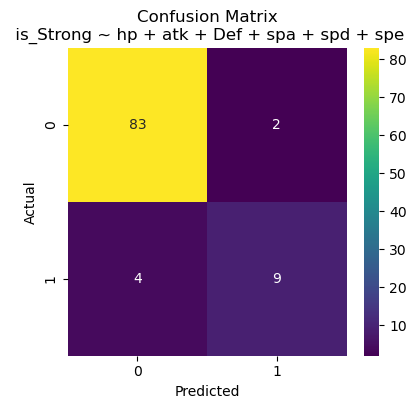

In [321]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

test.rename(columns={'def':'Def', 'Type 1': 'Type1', 'Type 2': 'Type2'}, inplace=True)
val.rename(columns={'def':'Def', 'Type 1': 'Type1', 'Type 2': 'Type2'}, inplace=True)

val["predictions"] = result_linearstats.predict(val) > 0.5
val["predictions"] = val["predictions"].astype(int)

confusion = confusion_matrix(val["is_Strong"], val["predictions"])


sns.heatmap(confusion, annot=True, fmt='g', cmap='viridis')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix\n is_Strong ~ hp + atk + Def + spa + spd + spe')
# change size
plt.rcParams['figure.figsize'] = [4.5, 4]
plt.show()

In [358]:
def make_is_tipo(tipo: str, df):
    df[f"is_{tipo}"] = df["Type1"].apply(lambda x: 1 if x == tipo else 0)
    df[f"is_{tipo}"] += df["Type2"].apply(lambda x: 1 if x == tipo else 0)
    df[f"is_{tipo}"] = df[f"is_{tipo}"].apply(lambda x: 1 if x == 2 else x)

tipos = ["Normal", "Dragon", "Psychic", "None"]
for tipo in tipos:
    make_is_tipo(tipo, data)
    make_is_tipo(tipo, test)
    make_is_tipo(tipo, val)

In [322]:
models = {}

def check_model(formula: str):
    model = sm.GLM.from_formula(formula, data=data, family=sm.families.Binomial())
    result_model = model.fit()
    print(result_model.summary())

    print_aic(result_model)

    val["predictions"] = result_model.predict(val) > 0.5
    val["predictions"] = val["predictions"].astype(int)

    confusion = confusion_matrix(val["is_Strong"], val["predictions"])
    accuracy = (val["predictions"] == val["is_Strong"]).sum() / len(val)
    true_positive_rate = confusion[1][1] / (confusion[1][1] + confusion[1][0])
    true_negative_rate = confusion[0][0] / (confusion[0][0] + confusion[0][1])
    precision = confusion[1][1] / (confusion[1][1] + confusion[0][1])

    models[formula] = {"model": model, "result": result_model, "aic": aic(result_model.llf, result_model.nobs, result_model.df_model),
                       "log_likelihood": result_model.llf,
                       "accuracy": accuracy, "true_positive_rate": true_positive_rate, 
                       "true_negative_rate": true_negative_rate, "precision": precision}

    print(f'Validation Accuracy: {accuracy}')
    print(f"True Positive Rate: {true_positive_rate}")
    print(f"True Negative Rate: {true_negative_rate}")
    print(f"Precision: {precision}")
    
    sns.heatmap(confusion, annot=True, fmt='g', cmap='viridis')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix\n {formula}')
    # change size
    plt.rcParams['figure.figsize'] = [4.5, 4]
    plt.show()
    return model

                 Generalized Linear Model Regression Results                  
Dep. Variable:              is_Strong   No. Observations:                  784
Model:                            GLM   Df Residuals:                      759
Model Family:                Binomial   Df Model:                           24
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -192.16
Date:                Mon, 26 Jun 2023   Deviance:                       384.32
Time:                        02:12:14   Pearson chi2:                     787.
No. Iterations:                    22   Pseudo R-squ. (CS):             0.3432
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           -33.6668   3.05e+0

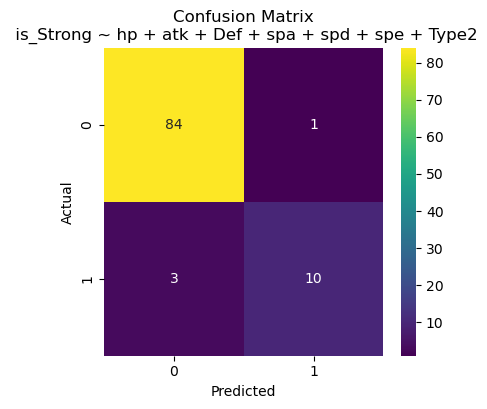

In [386]:
check_model('is_Strong ~ hp + atk + Def + spa + spd + spe + Type2')

                 Generalized Linear Model Regression Results                  
Dep. Variable:              is_Strong   No. Observations:                  784
Model:                            GLM   Df Residuals:                      758
Model Family:                Binomial   Df Model:                           25
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -192.15
Date:                Mon, 26 Jun 2023   Deviance:                       384.30
Time:                        01:24:31   Pearson chi2:                     788.
No. Iterations:                    22   Pseudo R-squ. (CS):             0.3433
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           -33.6833   3.04e+0

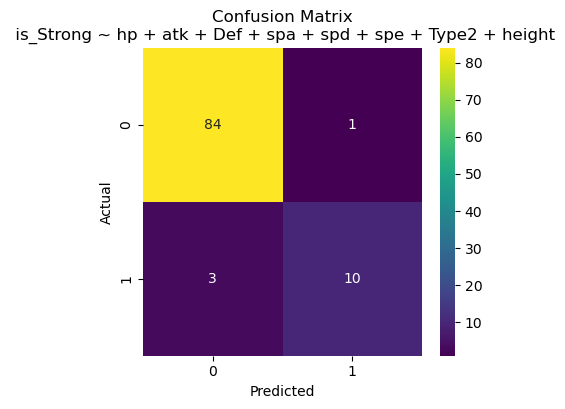

In [382]:
check_model('is_Strong ~ hp + atk + Def + spa + spd + spe + Type2 + height')

In [383]:
dfmodels = pd.DataFrame(models).T.sort_values(by=['accuracy', 'aic'], ascending=False)
dfmodels.drop(columns=['model', 'result'], inplace=True)
dfmodels

,aic,log_likelihood,accuracy,true_positive_rate,true_negative_rate,precision
is_Strong ~ hp + atk + Def + spa + spd + spe + Type2 + height + weight,435.458248,-191.729124,0.959184,0.769231,0.988235,0.909091
is_Strong ~ hp + atk + Def + spa + spd + spe + Type2 + height,434.304986,-192.152493,0.959184,0.769231,0.988235,0.909091
is_Strong ~ hp + atk + Def + spa + spd + spe + Type2 + weight,433.528104,-191.764052,0.959184,0.769231,0.988235,0.909091
is_Strong ~ hp + atk + Def + spa + spd + spe + Type2 + spe:weight,433.306879,-191.653439,0.959184,0.769231,0.988235,0.909091
is_Strong ~ hp + atk + Def + spa + spd + spe + Type2 + height:weight,433.143153,-191.571576,0.959184,0.769231,0.988235,0.909091
is_Strong ~ hp + atk + Def + spa + spd + spe + Type2,432.319371,-192.159686,0.959184,0.769231,0.988235,0.909091
is_Strong ~ atk + Def + spa + spd + spe + Type2,460.75079,-207.375395,0.94898,0.692308,0.988235,0.9
is_Strong ~ hp + atk + spa + spd + spe + Type2,455.981695,-204.990848,0.94898,0.769231,0.976471,0.833333
is_Strong ~ hp + atk + Def + spa + spe + Type2 + height:weight,440.322102,-196.161051,0.938776,0.615385,0.988235,0.888889
is_Strong ~ hp + atk + Def + spd + spe + Type2,440.304515,-197.152257,0.938776,0.692308,0.976471,0.818182


In [417]:
def check_model2(formula: str):
    model = sm.GLM.from_formula(formula, data=data, family=sm.families.Binomial())
    result_model = model.fit()
    print(result_model.summary())

    print_aic(result_model)

    test["predictions"] = result_model.predict(test) > 0.5
    test["predictions"] = test["predictions"].astype(int)

    confusion = confusion_matrix(test["is_Strong"], test["predictions"])
    accuracy = (test["predictions"] == test["is_Strong"]).sum() / len(test)
    true_positive_rate = confusion[1][1] / (confusion[1][1] + confusion[1][0])
    true_negative_rate = confusion[0][0] / (confusion[0][0] + confusion[0][1])
    precision = confusion[1][1] / (confusion[1][1] + confusion[0][1])

    models[formula] = {"model": model, "result": result_model, "aic": aic(result_model.llf, result_model.nobs, result_model.df_model),
                       "log_likelihood": result_model.llf,
                       "accuracy": accuracy, "true_positive_rate": true_positive_rate, 
                       "true_negative_rate": true_negative_rate, "precision": precision}

    print(f'Testidation Accuracy: {accuracy}')
    print(f"True Positive Rate: {true_positive_rate}")
    print(f"True Negative Rate: {true_negative_rate}")
    print(f"Precision: {precision}")
    # clear canvas
    plt.clf()
    
    sns.heatmap(confusion, annot=True, fmt='g', cmap='viridis')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix on Test Data\n {formula}')
    # change size
    plt.rcParams['figure.figsize'] = [6, 5]
    # add padding on left side
    plt.subplots_adjust(left=0.2)
    plt.savefig('confusion_matrix.png')
    plt.show()

    return model

                 Generalized Linear Model Regression Results                  
Dep. Variable:              is_Strong   No. Observations:                  784
Model:                            GLM   Df Residuals:                      759
Model Family:                Binomial   Df Model:                           24
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -192.16
Date:                Mon, 26 Jun 2023   Deviance:                       384.32
Time:                        02:37:21   Pearson chi2:                     787.
No. Iterations:                    22   Pseudo R-squ. (CS):             0.3432
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           -33.6668   3.05e+0

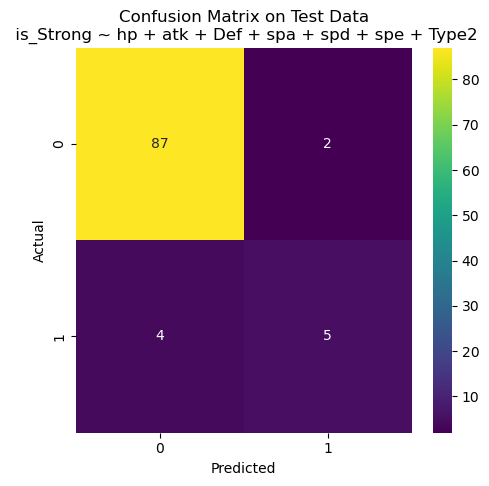

In [420]:
check_model2('is_Strong ~ hp + atk + Def + spa + spd + spe + Type2')

In [425]:
dataf["is_Strong"].sum()/len(dataf)

0.15816326530612246

In [430]:
train["is_Strong"].sum()/len(train)

0.16964285714285715

In [431]:
test["is_Strong"].sum()/len(test)

0.09183673469387756

In [432]:
val["is_Strong"].sum()/len(val)

0.1326530612244898